In [1]:
from scipy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 3.1.1

Here are 5-year averages of the worldwide temperature anomaly as compared to the 1951-1980 average (source: NASA).

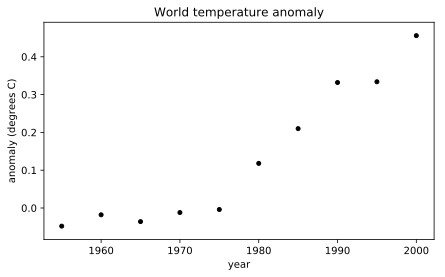

In [3]:
year = arange(1955,2005,5)
y = array([ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ])

fig,ax = subplots()
ax.scatter(year,y,color="k",label="data")
xlabel("year")
ylabel("anomaly (degrees C)")
title("World temperature anomaly");

A polynomial interpolant can be used to fit the data. Here we build one using a Vandermonde matrix. First, though, we express time as decades since 1950, as it improves the condition number of the matrix. 

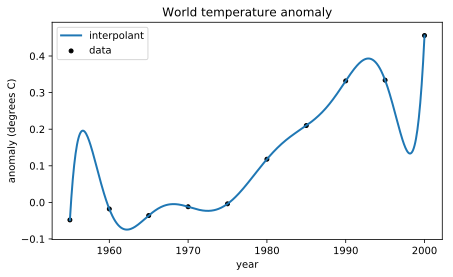

In [4]:
t = (year-1950)/10
V = vander(t)
c = solve(V,y)

p = poly1d(c)
tt = linspace(1955,2000,500)
ax.plot(tt,p((tt-1950)/10),label="interpolant")
ax.legend();
fig

As you can see, the interpolant does represent the data, in a sense. However it's a crazy-looking curve for the application. Trying too hard to reproduce all the data exactly is known as _overfitting_.

# Example 3.1.2

Here are the 5-year temperature averages again.

In [5]:
year = arange(1955,2005,5)
y = array([ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ])
t = (year-1950)/10

The standard best-fit line results from using a linear polynomial that meets the least squares criterion. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


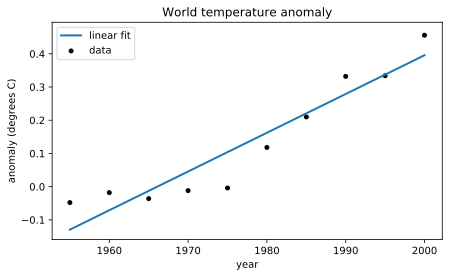

In [6]:
V = [ [t[i],1] for i in range(t.size) ]    # Vandermonde-ish matrix
c,res,rank,sv = lstsq(V,y)

fig,ax = subplots()
ax.scatter(year,y,color="k",label="data")

p = poly1d(c)
tt = linspace(1955,2000,500)
ax.plot(tt,p((tt-1950)/10),label="linear fit")

xlabel("year")
ylabel("anomaly (degrees C)")
title("World temperature anomaly");
ax.legend();

If we use a global cubic polynomial, the points are fit more closely.

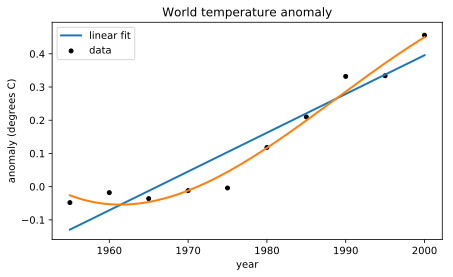

In [7]:
V = [ [t[i]**3,t[i]**2,t[i],1] for i in range(t.size) ]    # Vandermonde-ish matrix
c,res,rank,sv = lstsq(V,y,rcond=None)

p = poly1d(c)
ax.plot(tt,p((tt-1950)/10),label="cubic fit")
fig

If we were to continue increasing the degree of the polynomial, the residual at the data points would get smaller, but overfitting would increase.

# Example 3.1.3

Finding numerical approximations to $\pi$ has fascinated people for millenia. One famous formula is

$$ \frac{\pi^2}{6} = 1 + \frac{1}{2^2} + \frac{1}{3^2} + \cdots. $$


Say $s_k$ is the sum of the first  terms of the series above, and $p_k = \sqrt{6s_k}$. Here is a fancy way to compute these sequences in a compact code.

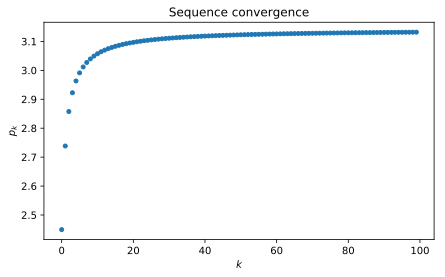

In [8]:
a = array([1/(k+1)**2 for k in range(100)])
s = cumsum(a)        # cumulative summation
p = sqrt(6*s)

plot(range(100),p,"o")
xlabel("$k$") 
ylabel("$p_k$") 
title("Sequence convergence");

This graph suggests that $p_k\to \pi$ but doesn't give much information about the rate of convergence. Let $\epsilon_k=|\pi-p_k|$ be the sequence of errors. By plotting the error sequence on a log-log scale, we can see a nearly linear relationship.

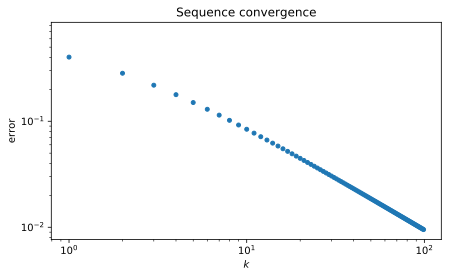

In [9]:
ep = abs(pi-p)    # error sequence
loglog(range(100),ep,"o")
xlabel("$k$") 
ylabel("error") 
title("Sequence convergence");

This suggests a power-law relationship where $\epsilon_k\approx a k^b$, or $\log \epsilon_k \approx b (\log k) + \log a$.

In [10]:
V = [ [1,log(k+1)] for k in range(100) ]     # fitting matrix
c = lstsq(V,log(ep),rcond=None)[0]           # coefficients of linear fit
print(c)

[-0.18237525 -0.96741032]


In terms of the parameters $a$ and $b$ used above, we have 

In [11]:
a,b = exp(c[0]),c[1]
print("b:",b)

b: -0.9674103233127624


It's tempting to conjecture that $b\to -1$ asymptotically. Here is how the numerical fit compares to the original convergence curve. 

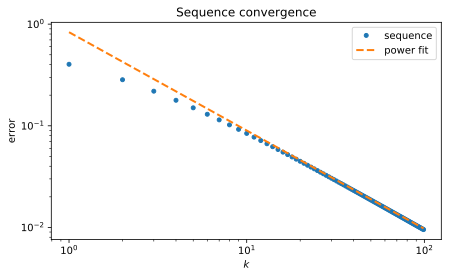

In [12]:
loglog(range(100),ep,"o",label="sequence")
k = arange(1,100)
plot(k,a*k**b,"--",label="power fit")
xlabel("$k$");  ylabel("error"); 
legend(); title("Sequence convergence");

# Example 3.2.1

Because the functions $\sin^2(t)$, $\cos^2(t)$, and $1$ are linearly dependent, we should find that the following matrix is somewhat ill-conditioned.

In [13]:
t = linspace(0,3,400)
A = array([ [ sin(t)**2,cos((1+1e-7)*t)**2,1 ] for t in t ])
kappa = cond(A)
print(kappa)

18253225.423474997


Now we set up an artificial linear least squares problem with a known exact solution that actually makes the residual zero.

In [14]:
x = array([1.,2,1])
b = A@x

Using backslash to find the solution, we get a relative error that is about $\kappa$ times machine epsilon.

In [15]:
x_BS = lstsq(A,b,rcond=None)[0]
print("observed error:",norm(x_BS-x)/norm(x))
print("max error:",kappa/2**52)

observed error: 5.720935424786891e-11
max error: 4.053030227763043e-09


If we formulate and solve via the normal equations, we get a much larger relative error. With $\kappa^2\approx 10^{14}$, we may not be left with more than about 2 accurate digits.

In [16]:
N = A.T@A
x_NE = solve(N,A.T@b)
print("observed error:",norm(x_NE-x)/norm(x))
print("digits:",-log10(norm(x_NE-x)/norm(x)))

observed error: 0.014430750140516358
digits: 1.840711092785969


# Example 3.3.1

We can access both the thin and full forms of the QR factorization. Thin is the default (we use the `numpy` version here, not the `scipy` version).

In [17]:
A = 1.0 + floor(9*rand(6,4))
A.shape

(6, 4)

Here is a standard call:

In [18]:
Q,R = qr(A)
print("Q:",Q)
print("R:",R)

Q: [[-0.39562828  0.01154385  0.66183202 -0.16033665]
 [-0.52750438 -0.27961762 -0.38452464 -0.34909066]
 [-0.19781414  0.59579075 -0.31461232  0.57327076]
 [-0.39562828  0.45405797 -0.27739004 -0.46855752]
 [-0.39562828 -0.57847498 -0.22169437  0.46898296]
 [-0.46156633  0.16097253  0.43479263  0.29034004]]
R: [[-15.16575089 -14.96793675 -13.91292799 -18.79234349]
 [  0.           6.77944464   3.50355747   1.72837038]
 [  0.           0.          -6.86698768  -2.69230617]
 [  0.           0.           0.           4.19667123]]


We can test that $\mathbf{Q}$ has orthonormal columns.

In [19]:
norm(Q.T@Q - eye(4))

5.698449006506434e-16

Here's the full or "complete" factorization.

In [20]:
Q,R = qr(A,"complete")
print(Q.shape)

(6, 6)


In [21]:
norm(Q.T@Q - eye(6))

7.028964605098547e-16

# Example 3.4.1

We will use Householder reflections to produce a QR factorization of the matrix

In [22]:
A = 1.0 + floor(9*rand(6,4))
m,n = A.shape

Our first step is to introduce zeros below the diagonal in column 1. Define the vector 

In [23]:
z = A[:,0]

Applying the Householder definitions gives us

In [24]:
v = z - norm(z)*hstack([1,zeros(m-1)])
P = eye(m) - (2/dot(v,v))*outer(v,v)   # reflector

By design we can use the reflector to get the zero structure we seek:

In [25]:
P@z

array([1.51327460e+01, 1.77635684e-15, 2.22044605e-16, 1.77635684e-15,
       4.44089210e-16, 1.77635684e-15])

Now we let 

In [26]:
A = P@A
print(A)

[[ 1.51327460e+01  8.78888739e+00  1.23573078e+01  1.33485357e+01]
 [ 4.44089210e-16  2.95965221e-01 -3.19328443e+00  3.25713747e+00]
 [ 4.44089210e-16  6.12684224e+00  1.91716382e+00  3.39591606e+00]
 [ 1.33226763e-15 -3.70403478e+00 -1.93284428e-01 -7.42862533e-01]
 [ 4.44089210e-16  4.12684224e+00  5.91716382e+00  3.95916057e-01]
 [ 1.33226763e-15 -6.66175403e+00 -3.22089649e+00  1.72244282e+00]]


We are set to put zeros into column 2. We must not use row 1 in any way, lest it destroy the zeros we just introduced. To put it another way, we can repeat the process we just did on the smaller submatrix

In [27]:
A[1:,1:]

array([[ 0.29596522, -3.19328443,  3.25713747],
       [ 6.12684224,  1.91716382,  3.39591606],
       [-3.70403478, -0.19328443, -0.74286253],
       [ 4.12684224,  5.91716382,  0.39591606],
       [-6.66175403, -3.22089649,  1.72244282]])

In [28]:
z = A[1:,1]
v = z - norm(z)*hstack([1,zeros(m-2)])
P = eye(m-1) - (2/dot(v,v))*outer(v,v)

We now apply the reflector to the submatrix.

In [29]:
A[1:,1:] = P@A[1:,1:]
print(A)

[[ 1.51327460e+01  8.78888739e+00  1.23573078e+01  1.33485357e+01]
 [ 4.44089210e-16  1.06186373e+01  5.40493204e+00  1.38259009e+00]
 [ 4.44089210e-16  5.03347835e-16 -3.18615782e+00  4.50852101e+00]
 [ 1.33226763e-15 -8.42552260e-16  2.89197223e+00 -1.41549735e+00]
 [ 4.44089210e-16  3.02741362e-16  2.47973186e+00  1.14533067e+00]
 [ 1.33226763e-15 -7.57231852e-16  2.32797717e+00  5.12700474e-01]]


We need two more iterations of this process.

In [30]:
for j in [2,3]:
    z = A[j:,j]
    v = z - norm(z)*hstack([1,zeros(m-j-1)])
    P = eye(m-j) - (2/dot(v,v))*outer(v,v)
    A[j:,j:] = P@A[j:,j:]

We have now reduced the original  to an upper triangular matrix using four orthogonal Householder reflections:

In [31]:
R = A
print(R)

[[ 1.51327460e+01  8.78888739e+00  1.23573078e+01  1.33485357e+01]
 [ 4.44089210e-16  1.06186373e+01  5.40493204e+00  1.38259009e+00]
 [ 4.44089210e-16  5.03347835e-16  5.48485668e+00 -2.62992661e+00]
 [ 1.33226763e-15 -8.42552260e-16  5.08664073e-16  4.12171379e+00]
 [ 4.44089210e-16  3.02741362e-16  1.59937231e-16  0.00000000e+00]
 [ 1.33226763e-15 -7.57231852e-16  4.64488592e-16  0.00000000e+00]]
